# Using the data from SQL Results to analyze taxi data and make recommendations for a new ride share company

**Introduction**
For this project I am functioning as an analyst for Zuber: a ride sharing company launching in Chicago. I will take data about Taxi companies and consumer usage to give insights to Zuber to help with a successful data based launch.

In the prework for this project I used data collected from https://practicum-content.s3.us-west-1.amazonaws.com/data-analyst-eng/moved_chicago_weather_2017.html to make a csv of the weather in Chicago during November, 2017. I also created csv's that have information about the taxi companies and their pickup/dropoff patterns.  

In the remaining portion of analysis seen below I clean up the data from the csv's and then I show comparisons between the different companies and where there is the most traffic.

I also will show how weather impacts taxi rides so that Zuber will know how to plan for their launch, Rain or Shine.

In [1]:
#Importing necessary tools
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st

In [2]:
#importing the files and making new DataFrames
company = pd.read_csv('moved_project_sql_result_01.csv')
dropoff = pd.read_csv('moved_project_sql_result_04.csv')
weather_time = pd.read_csv('moved_project_sql_result_07.csv')

In [3]:
#get a firs look at the data
display(company.head())
display(dropoff.head())
display(weather_time.head())

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


In [4]:
#study the data they contain
company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


Data types make sense and there are now null values.

In [5]:
dropoff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


Data types make sense and there are no missing values

In [6]:
weather_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


In [7]:
#Sort the values in the company data in descending order based on trips_amount column
company.sort_values(by='trips_amount', ascending=False, inplace=True)
#check to see what the least amount of rides vs most amount of rides look like
display(company.tail())
display(company.head())

,company_name,trips_amount
59,4053 - 40193 Adwar H. Nikola,7
60,2733 - 74600 Benny Jona,7
61,5874 - 73628 Sergey Cab Corp.,5
62,"2241 - 44667 - Felman Corp, Manuel Alonso",3
63,3556 - 36214 RC Andrews Cab,2


,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


The weather_conditions and duration_seconds colums have data types that make sense. There are no missing values in the whole dataframe. The start_ts data type will need to be converted to datetime.

In [8]:
#converting the 'start_ts' from object to datetime
weather_time['start_ts'] = pd.to_datetime(weather_time['start_ts'])
#sorting the values by their date and time so that I can compare the values
weather_time.sort_values(by='start_ts', inplace=True)

In [9]:
#Checking for duplicates
print('There are', company.duplicated().sum(), 'duplicates in the company DataFrame')
print('There are', dropoff.duplicated().sum(), 'duplicates in the dropoff DataFrame')
print('There are', weather_time.duplicated().sum(), 'duplicates in the weather_time DataFrame')


There are 0 duplicates in the company DataFrame
There are 0 duplicates in the dropoff DataFrame
There are 197 duplicates in the weather_time DataFrame


In finding out that there are nearly 200 duplicated rows I'm going to need to inspect them and see if they need to be dropped.

In [10]:
#take a look at the duplicates to see if they really are duplicated values
duplicates = weather_time.duplicated(keep=False)
print(weather_time[duplicates].head(20))

                start_ts weather_conditions  duration_seconds
541  2017-11-04 05:00:00               Good            1200.0
462  2017-11-04 05:00:00               Good            1200.0
681  2017-11-04 06:00:00               Good            1267.0
682  2017-11-04 06:00:00               Good            1267.0
833  2017-11-04 07:00:00               Good            1440.0
933  2017-11-04 07:00:00               Good            1200.0
1025 2017-11-04 07:00:00               Good            1380.0
1020 2017-11-04 07:00:00               Good            1260.0
332  2017-11-04 07:00:00               Good            1140.0
363  2017-11-04 07:00:00               Good            1440.0
979  2017-11-04 07:00:00               Good            1140.0
262  2017-11-04 07:00:00               Good            1380.0
561  2017-11-04 07:00:00               Good            1260.0
231  2017-11-04 07:00:00               Good            1200.0
626  2017-11-04 08:00:00               Good            1260.0
655  201

On closer inspection, it really appears that most of the weather_time duplicates are duplicated data. The duration in seconds column makes the compelling case that if there are 2 rows where the length of time of a ride is the exact same at the starting at the same time of day on the same date, then it is most likely a true duplicate. Otherwise it would mean that a two taxis picked up and dropped off at the same time on this route, which seems farfetched. 

There are a few that do not seem to be true duplicates, but in order to clear up the data more effectively and get a clearer picture of all the rides in this dataframe I will be dropping the duplicates for this dataset.

In [11]:
#remove duplicates in the weather_time dataframe
weather_time.drop_duplicates()

,start_ts,weather_conditions,duration_seconds
893,2017-11-04 00:00:00,Good,1560.0
552,2017-11-04 01:00:00,Good,0.0
267,2017-11-04 02:00:00,Good,2956.0
741,2017-11-04 04:00:00,Good,1595.0
88,2017-11-04 04:00:00,Good,1333.0
...,...,...,...
1045,2017-11-25 18:00:00,Good,2520.0
479,2017-11-25 19:00:00,Good,2280.0
154,2017-11-25 20:00:00,Good,1980.0
25,2017-11-25 20:00:00,Good,2100.0


In [12]:
#identify the top 10 neighborhoods in terms of drop-offs
dropoff_sorted = dropoff.sort_values(by='average_trips', ascending=False)
popular_neighborhoods = dropoff_sorted.head(10)
display(popular_neighborhoods)

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


In [13]:
#Compare the top Taxi companies in the percentage of the market captured by their services
total_rides = company['trips_amount'].sum()
print('There were a total of', total_rides, 'taxi rides in November 2017')
flash_cab_rides = company['trips_amount'].iloc[0]
flash_cab_share = (flash_cab_rides/total_rides)*100
TAS_rides = company['trips_amount'].iloc[1]
TAS_share = (TAS_rides/total_rides)*100
print(f'Flash Cab captured {flash_cab_share:.1f}% of the total taxi rides for November 2017')
print(f'Taxi Affiliation Services captured {TAS_share:.1f}% of the total taxi rides for November 2017')

There were a total of 137311 taxi rides in November 2017
Flash Cab captured 14.2% of the total taxi rides for November 2017
Taxi Affiliation Services captured 8.3% of the total taxi rides for November 2017


<Axes: title={'center': 'Rides Count from Taxi Companies in Chicago'}, xlabel='Company', ylabel='Rides'>

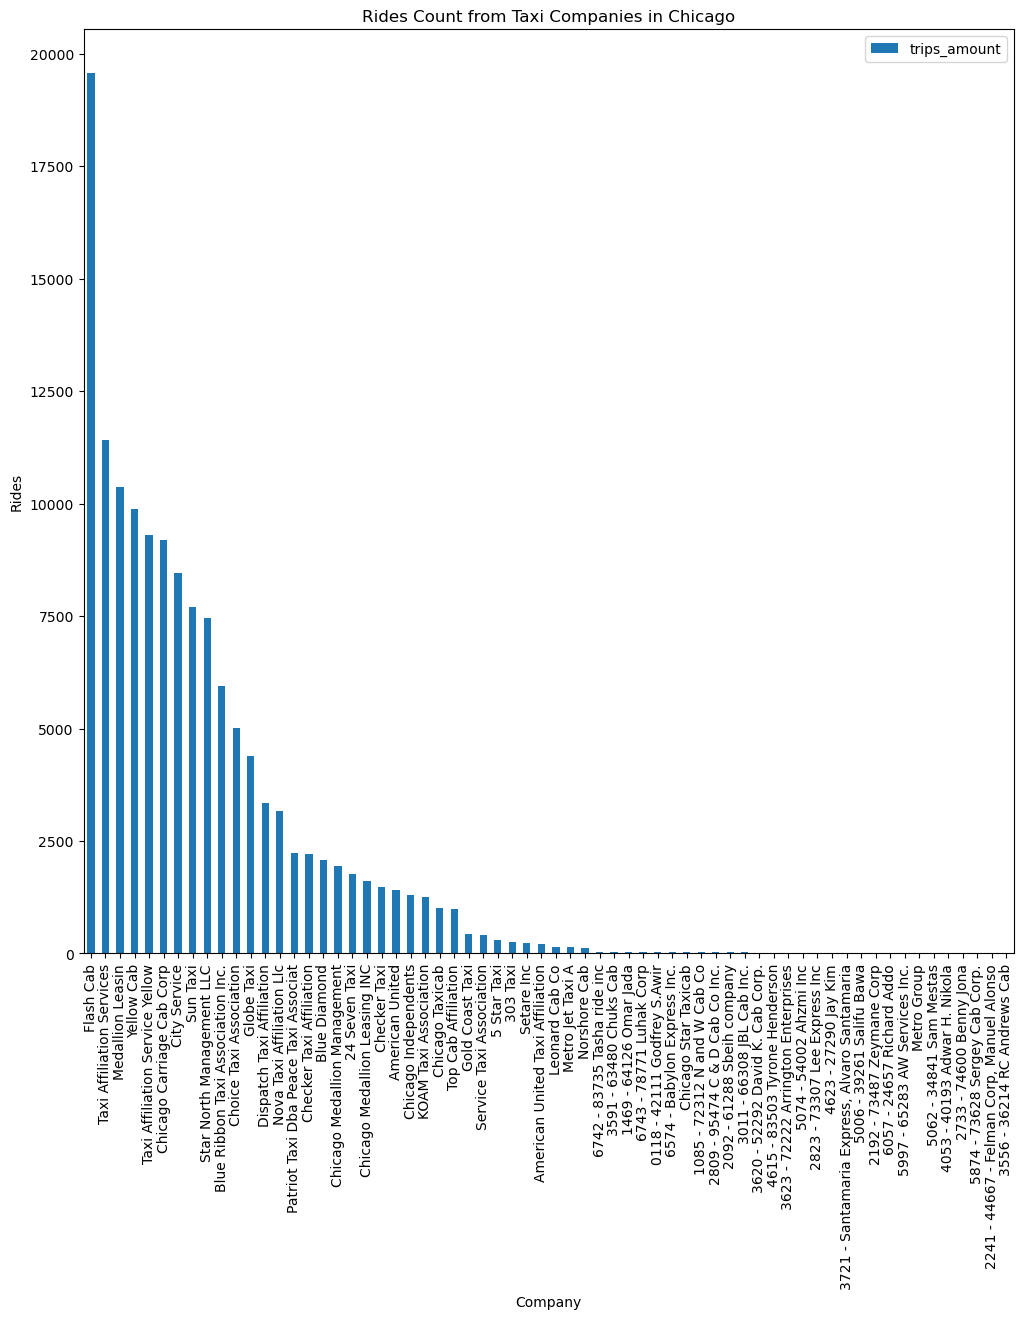

In [14]:
#graph taxi companies and number of rides,
company.plot(x='company_name', y='trips_amount', kind='bar',figsize=[12,12], title='Rides Count from Taxi Companies in Chicago', xlabel='Company', ylabel='Rides')

There is a large volume of companies that have very few rides in their data, so I'm also going to make a graph that shows a comparison of just the top 15 companies compared.

<Axes: title={'center': 'Rides Count from Taxi Companies in Chicago'}, xlabel='Company', ylabel='Rides'>

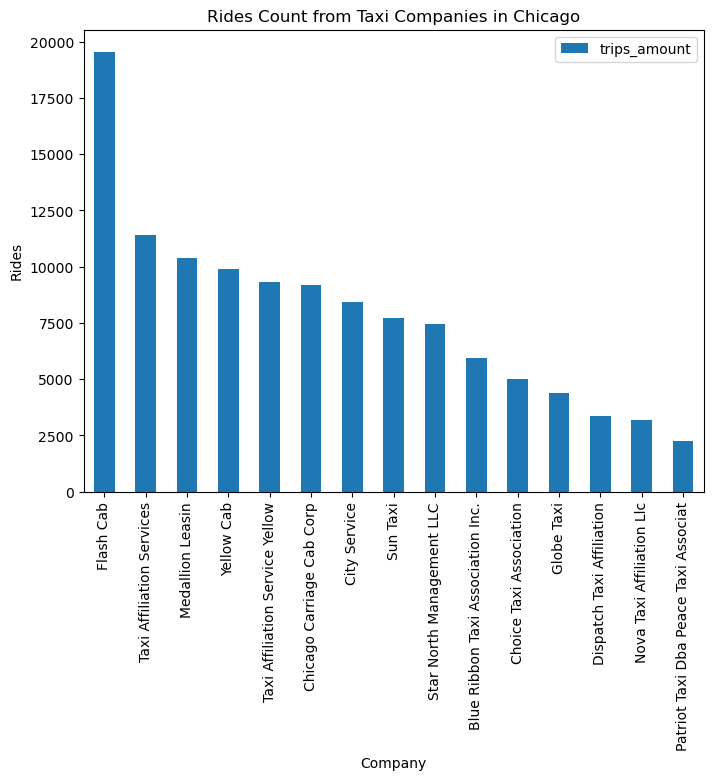

In [15]:
#Make a graph only showing the top 15 companies
top_companies = company.head(15)
top_companies.plot(x='company_name', y='trips_amount', kind='bar',figsize=[8,6], title='Rides Count from Taxi Companies in Chicago', xlabel='Company', ylabel='Rides')


<Axes: title={'center': 'Top Ten Neigborhoods'}, xlabel='Neighborhood', ylabel='Average Trips'>

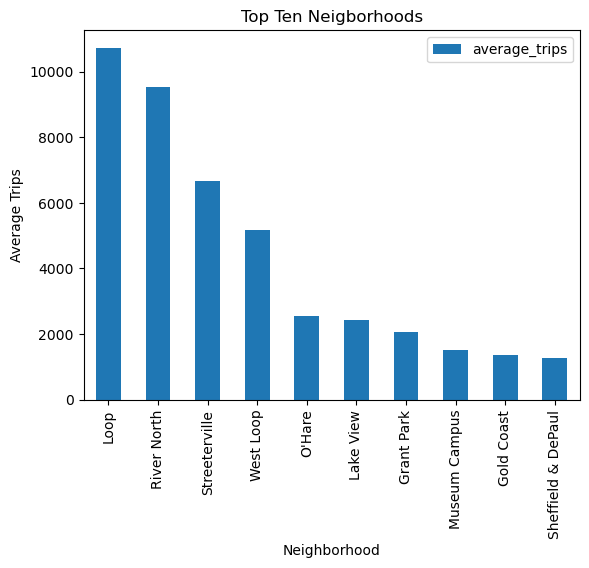

In [16]:
#Graph top 10 neighborhoods by number of dropoffs
popular_neighborhoods.plot(x='dropoff_location_name', y='average_trips', kind='bar', title='Top Ten Neigborhoods', xlabel='Neighborhood', ylabel='Average Trips')

The Flash CAB company does a significantly greater volume of rides than other companies. It would be worth exploring in more depth how they have set up their business to capture so much of the market. The "Loop" neighborhood is the most popular destination in Chicago.This neighborhood houses several of Chicago's most famous tourist attractions including Millenium Park, Navy Pier, and several Museums. People coming in from out of town will likely use public transportation such as taxis to visit this popular part of town.

In [17]:
#display the data so that I don't have to keep scrolling to the top
weather_time.head()

,start_ts,weather_conditions,duration_seconds
893,2017-11-04 00:00:00,Good,1560.0
552,2017-11-04 01:00:00,Good,0.0
267,2017-11-04 02:00:00,Good,2956.0
741,2017-11-04 04:00:00,Good,1595.0
88,2017-11-04 04:00:00,Good,1333.0


In [18]:
#Define data for different weather conditions
rainy = weather_time[weather_time['weather_conditions'] == 'Bad']
sunny = weather_time[weather_time['weather_conditions']== 'Good']
#Find the average duration of rides for each category
avg_rainy = rainy['duration_seconds'].mean()
print(f'The average duration of rides in rainy weather was {avg_rainy:.1f} seconds.')
avg_sunny = sunny['duration_seconds'].mean()
print(f'The average duration of rides in sunny weather was {avg_sunny:.1f} seconds.')

The average duration of rides in rainy weather was 2427.2 seconds.
The average duration of rides in sunny weather was 1999.7 seconds.


NUll Hypothesis: There is no difference in the duration of rides in rainy vs sunny weather

Alternative Hypothesis: There is a statistically significant difference between ride duration in rainy vs sunny weather.

I will be setting the Alpha to .05 as this would be stringent enough to get a clear picture of a trend such as this.

In [19]:
#isolate the duration of the rides column
rainy_dur = rainy['duration_seconds']
sunny_dur = sunny['duration_seconds']

#perform the t-test
results = st.ttest_ind(rainy_dur, sunny_dur, equal_var=False)
alpha = .05
# Print the p-value and hypothesis testing result for genres
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 6.738994326108734e-12
We reject the null hypothesis


Because we reject the null hypothesis we can see that there is a statistically signficant difference in the duration of rides based on the weather conditions. From the earlier analysis we can see that on average the length of a ride in the rain is 40:27 minutes and in sunny conditions 33:20 minutes.

## Conclusion ##
As a data analyst for Zuber I used data regarding the taxi companies and their consumer behaviors in Chicago to help the company's launch in the city have data based information for making quality decisions.
Methods:
I compiled web data using SQL in order to create usable CSV files. I then took these files and began exploring the data contained in them. The files contained information about the Taxi Companies in Chicago, the dropoff patterns for each of Chicago's neighborhoods, and the weather for the month of November, 2017. First, I converted the datatypes of columns that needed to be changed, then I removed duplicated information. After doing these tasks I was able to look into some of the trends for consumers in which taxi companies they're using most and which neighborhoods they prefer to travel to. I created several graphs to display the information from the charts in a clear visual that demonstrate these trends. Finally, I used statistical analysis to show that weather affects taxi driving patterns.

Competition Findings:
Flash Cab is the most popular cab company in Chicago during November, 2017, having completed nearly 20,000 rides during the month which captured 14.2% of all the taxi rides during that period. The next highest volume company had only 11,400 rides with 8.3% market capture. With more than 60 different companies offering rides, there is certainly room for Zuber to enter and offer a compelling alternative to these top performers. 

Neighborhood Findings:
Chicago is home to one of the largest airport hubs in the country, and with a wide range of tourist activities, there are activities that would appeal to just about anyone. While researching the different neighborhoods in Chicago, the "Loop" neighborhood received the most amount of visitors during the month. The "Loop" contains museums, parks, and the world famous Navy Pier. From this data it appears that there is quite a bit of tourist traffic using taxi services to navigate the Windy City.

Weather Findings:
Weather is a big factor for people as they travel, and it is important to discern how it affects traffic in a big city when looking to launch a rideshare company like Zuber. During November, hours when it was raining outside had significantly longer commute times compared to clear skies. I found that ride times from O'Hare Airport to The Loop neighborhood lasted more than 7 minutes longer per ride when it was raining outside. This showed a clear trend that weather affects drive time in Chicago.

Continued Research Recommendations:
From this data it would make sense for Zuber to look more closely into how Flash Cab is capturing a larger share of the market than other companies. Perhaps they have a larger fleet of cabs, or perhaps they have recently launched marketing campaigns with incentives that make them the more compelling offering to consumers. A deeper understaning of what Flash Cab has done well can help with making quality decisions as well.

A closer look at the times each neighborhood is busy and receiving the most taxi traffic could also be helpful for further strategic exploration.

Launch Recommendations:
Because the Loop Neighborhood is the most popular area of town for taxi users to visit, it will be helpful to have optimized driving routes from other parts of the city to the Loop Neighborhood. In addition to that, there will be many more people in the Loop neighborhood looking for transportation when they're done with their day's activities, so it would also be helpful to keep a portion of the fleet available in the Loop neighborhood especially in the late afternoon as consumers will be heading out of the area back to their accommodations.

On sunny days traffic will be moving at a faster pace, so the average cab ride time will be lower, but each driver may end up with more volume in rides offered over the course of the day. When traking KPIs for the drivers keeping in mind weather conditions will help with undestanding dips o